# Overcoming Small Minirhizotron Datasets Using Transfer Learning
Author: Weihuang Xu, Guohao Yu, Alina Zare, Brendan Zurweller, Diane Rowland, Joel Reyes-Cabrera, Felix B Fritschi, Roser Matamala, Thomas E. Juenger

This is a demo to show the segmentation performance using Unet architecture on Plant roots minirhizotron images.
We compared the pre-trained features from massive ImageNet dataset and our mid-size peanut root dataset for segmentation experiments on limited switchgrss root dataset.

Github:https://github.com/GatorSense/PlantRootSeg

In [1]:
# Import dependencies
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.transforms import Compose, ToTensor, ToPILImage
import PIL.Image as Image
from time import time
from UNetmodel import UNet
import torch.nn.functional as F
import os
import numpy as np
%matplotlib notebook

In [3]:
# Segmentation results on peanut root minirhizotron images. Model was trained on our peanut root dataset.
model_dir = './Models/Peanut_UnetD5.pth'
device = torch.device('cpu')
UNet = UNet(num_classes=1, depth=5)
UNet.load_state_dict(torch.load(model_dir, map_location=device))
UNet.eval()

TypeError: forward() got an unexpected keyword argument 'num_classes'

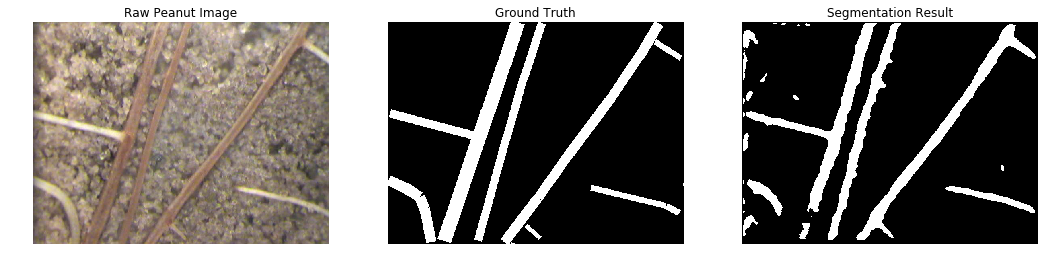

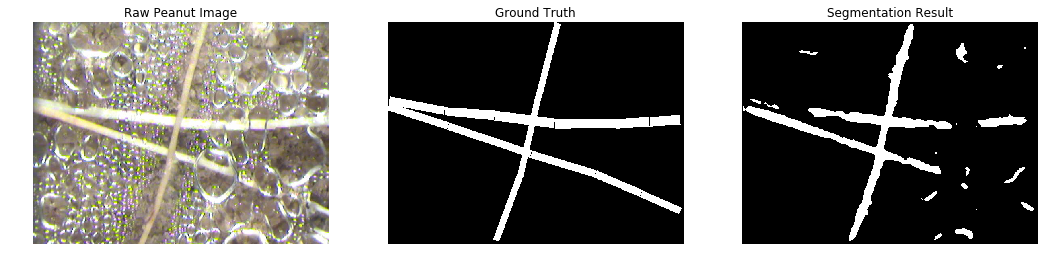

In [5]:
# Show segmentation results on peanut root images
peanut_path = './Img/Peanut_Roots/Image'
peanutGT_path = './Img/Peanut_Roots/GT'
T = 0.5
for img in os.listdir(peanut_path):
    img_dir = os.path.join(peanut_path, img)
    GT_dir = os.path.join(peanutGT_path, ('GT'+ '_' + img))
    input = Image.open(img_dir).convert('RGB')
    input = ToTensor()(input).unsqueeze(0)
    GT = Image.open(GT_dir).convert('L')

    with torch.no_grad():
        input = input
        output = UNet(input)        
        pred = output[0,0]
        pred = torch.sigmoid(pred)
        pred = (pred-pred.min())/(pred.max() - pred.min())
        pred = pred < T
        plt.figure(frameon=False, figsize=(18,16))
        plt.subplot(1,3,1)
        plt.imshow(ToPILImage()(input[0]))
        plt.axis('off')
        plt.title('Raw Peanut Image')
        plt.subplot(1,3,2)
        plt.imshow(GT, cmap='binary')
        plt.axis('off')
        plt.title('Ground Truth')
        plt.subplot(1,3,3)
        plt.imshow(pred.numpy(), cmap='binary')
        plt.axis('off')
        plt.title('Segmentation Result')
        plt.show()

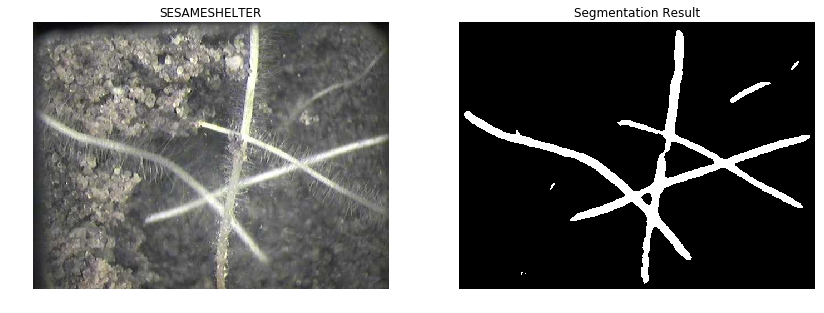

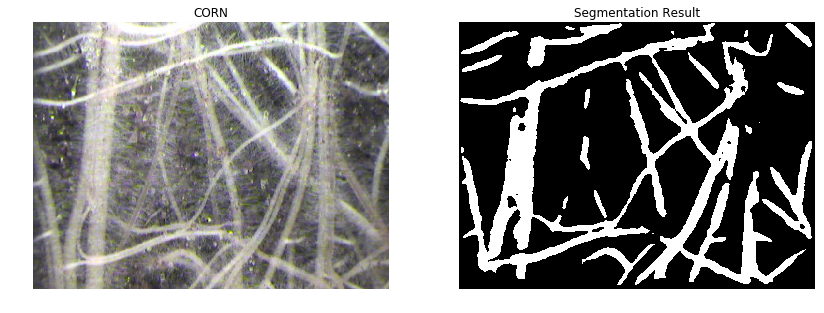

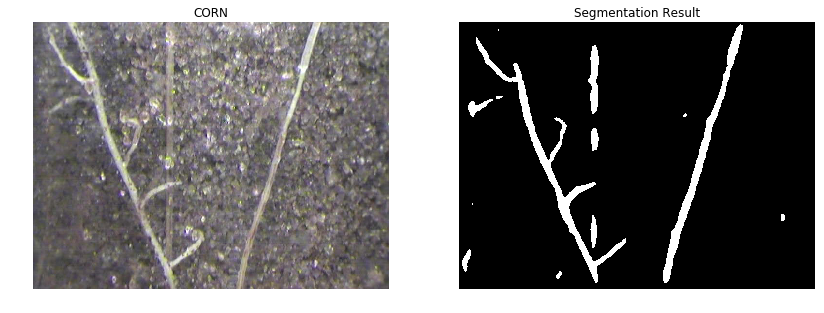

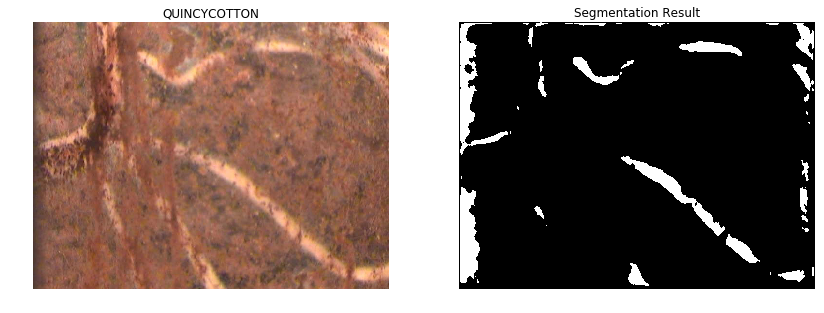

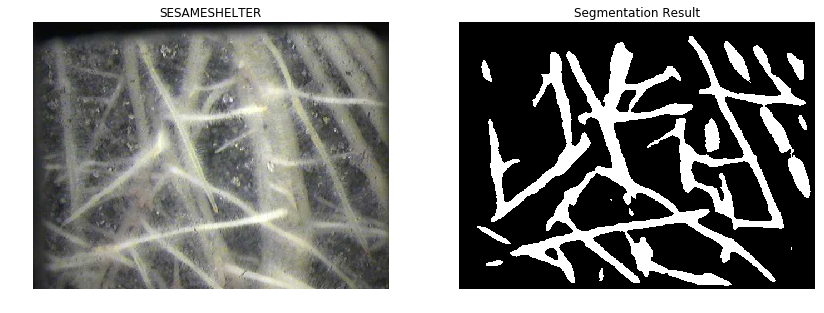

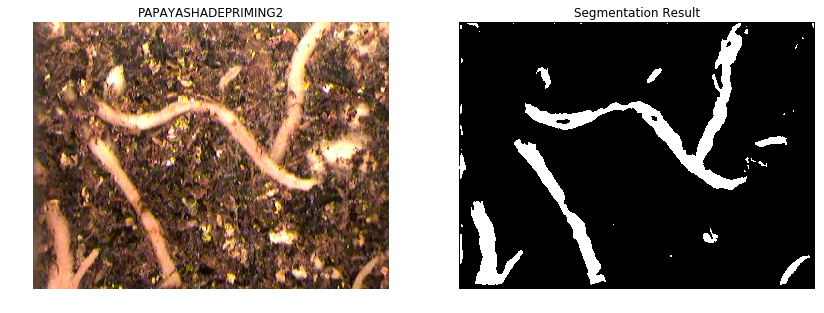

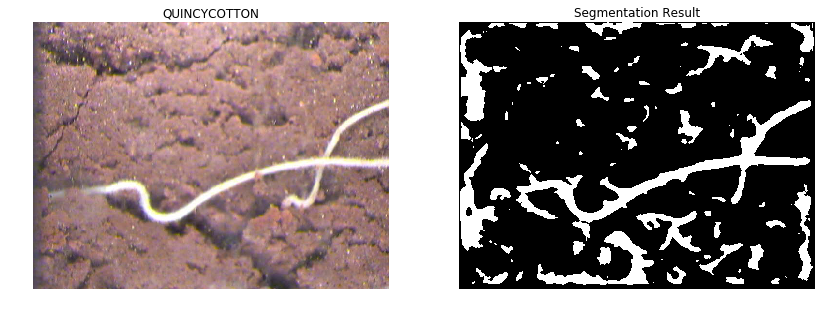

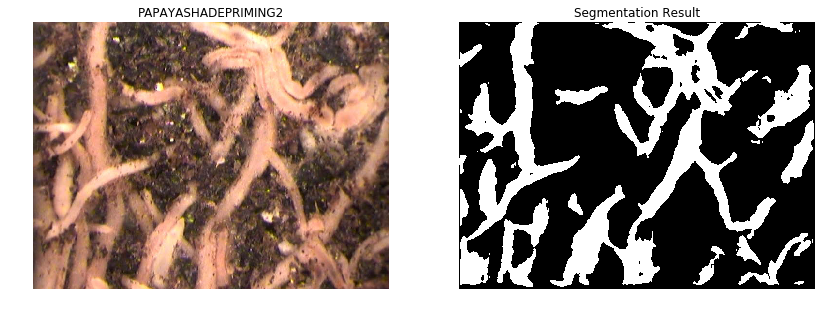

In [13]:
# Show segmentation results of other root images including corn, papay, cotton and sesame.
# We use the same model(trained from peanut root dataset) as above. We apply the model on other types of plant root
# images without finetuning to see the generability of those features learned from peanut root datset.

image_path = './Img/Other_Roots/'
T = 0.5
for img in os.listdir(image_path):
    img_dir = os.path.join(image_path, img)
    input = Image.open(img_dir).convert('RGB')
    input = ToTensor()(input).unsqueeze(0)

    with torch.no_grad():
        input = input
        output = UNet(input)        
        pred = output[0,0]
        pred = torch.sigmoid(pred)
        pred = (pred-pred.min())/(pred.max() - pred.min())
        pred = pred < T
        plt.figure(frameon=False, figsize=(14,12))
        plt.subplot(1,2,1)
        plt.imshow(ToPILImage()(input[0]))
        plt.axis('off')
        plt.title('%s' %(img.split('_')[0]))
        plt.subplot(1,2,2)
        plt.imshow(pred.numpy(), cmap='binary')
        plt.axis('off')
        plt.title('Segmentation Result')
        plt.show()

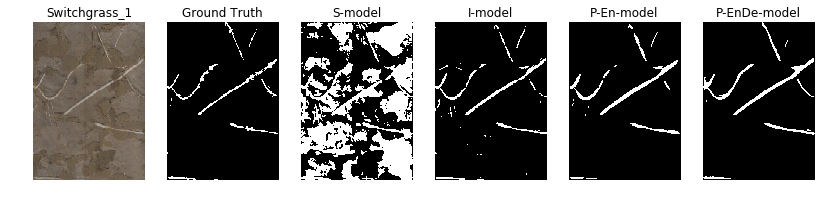

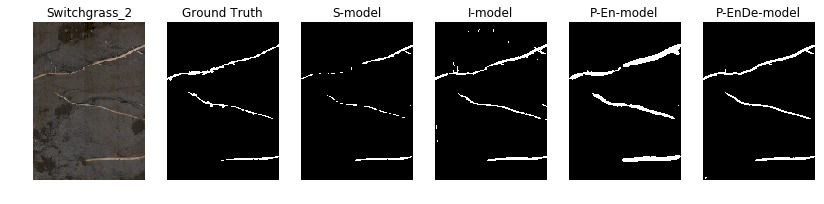

In [26]:
# Show segmentation results of switchgrass root images. 
# Models with different pre-trained features are used:
# S-model, weights in both encoder and decoder are randomly initialized. Base line.
# I-model, weights in encoder are initialized with ImageNet pre-trained features and randomly initialized weights in decoder. 
# P-En-model, weights in encoder are initialized with peanut pre-trained features and randomly initialized weights in decoder. 
# P-EnDe-model, weights in both encoder and decoder are initialized with peanut pre-trained features.

models = ['S-model.pth', 'I-model.pth', 'P-En-model.pth', 'P-EnDe-model.pth']
T = [0.1694, 0.4918, 0.9200, 0.7735] # thresholds for each model are picked based on 0.01 FPR, details are shown in the paper
model_path = './Models/'
switchgrass_path = './Img/Switchgrass_Roots/Image'
switchgrassGT_path = './Img/Switchgrass_Roots/GT'
for img in os.listdir(switchgrass_path):
    img_dir = os.path.join(switchgrass_path, img)
    GT_dir = os.path.join(switchgrassGT_path, ('GT'+ '_' + img))
    input = Image.open(img_dir).convert('RGB')
    input = ToTensor()(input).unsqueeze(0)
    GT = Image.open(GT_dir).convert('L')
    plt.figure(frameon=False, figsize=(14,12))
    plt.subplot(1,6,1)
    plt.imshow(ToPILImage()(input[0]))
    plt.axis('off')
    plt.title('%s' %(img.split('.')[0]))
    plt.subplot(1,6,2)
    plt.imshow(GT, cmap='binary')
    plt.axis('off')
    plt.title('Ground Truth')
    for i in range(len(models)):
        model_dir = os.path.join(model_path, models[i])
        UNet.load_state_dict(torch.load(model_dir, map_location=device))
        UNet.eval()
        with torch.no_grad():
            input = input
            output = UNet(input)        
            pred = output[0,0]
            pred = torch.sigmoid(pred)
            pred = (pred-pred.min())/(pred.max() - pred.min())
            pred = pred < T[i]
            
            plt.subplot(1,6,i+3)
            plt.imshow(pred.numpy(), cmap='binary')
            plt.axis('off')
            plt.title('%s' %(models[i].split('.')[0]))
            
    plt.show()